In [70]:
import tensorflow as tf
from google.colab import drive
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [71]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 350

In [72]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [73]:
import zipfile
import os

# Path to the ZIP file in your Google Drive
zip_file_path = '/content/drive/MyDrive/CassavaDisease/DiseaseCassavaNew.zip'

# Directory to extract the contents of the ZIP file
extracted_dir_path = '/content/dataset/'

# Create the directory if it doesn't exist
os.makedirs(extracted_dir_path, exist_ok=True)

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir_path)

# List the contents of the extracted directory
extracted_files = os.listdir(extracted_dir_path)
print("Extracted Files:", extracted_files)

Extracted Files: ['Cassava Green Mottle (CGM)', 'Cassava Mosaic Disease (CMD)', 'Cassava Bacterial Blight (CBB)', 'Cassava Brown Streak Disease (CBSD)', 'Healthy']


In [74]:
extracted_dir_path = "/content/dataset"
dataset = tf.keras.utils.image_dataset_from_directory(
    extracted_dir_path,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2212 files belonging to 5 classes.


In [75]:
class_names = dataset.class_names
class_names

['Cassava Bacterial Blight (CBB)',
 'Cassava Brown Streak Disease (CBSD)',
 'Cassava Green Mottle (CGM)',
 'Cassava Mosaic Disease (CMD)',
 'Healthy']

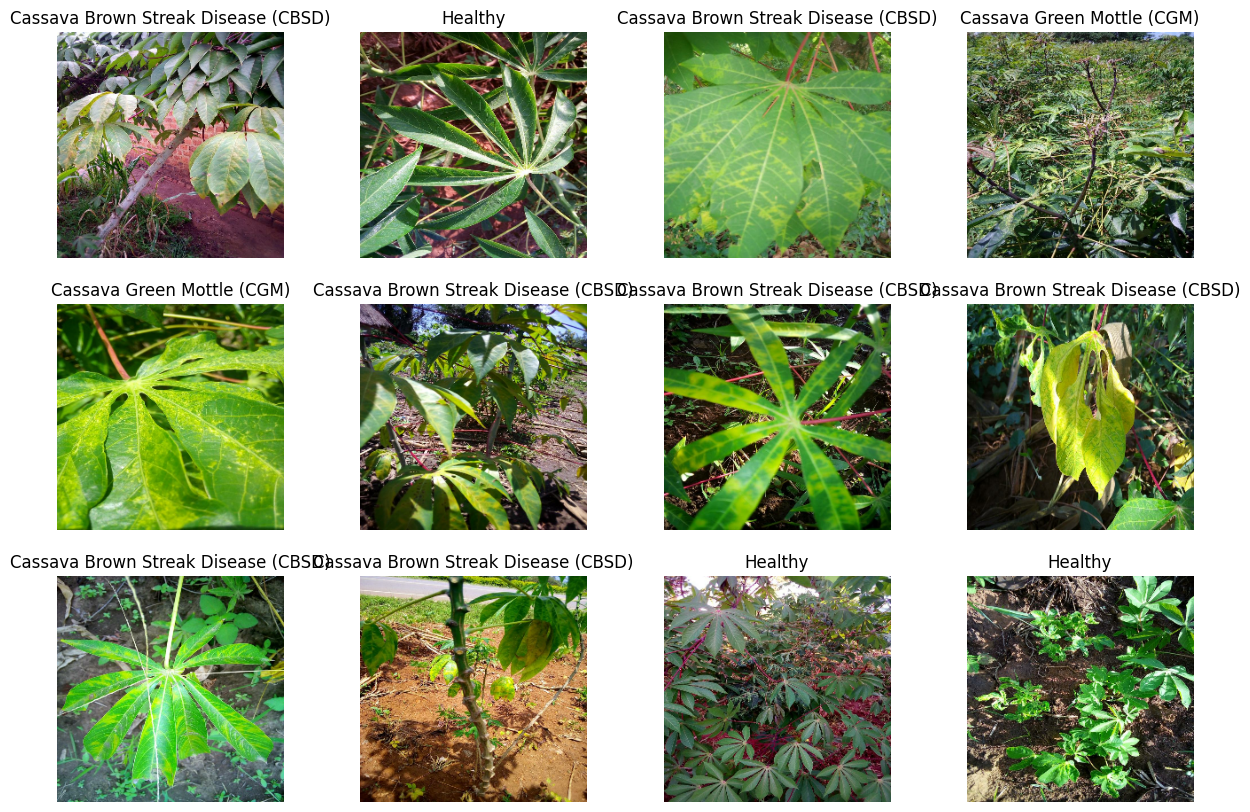

In [76]:
plt.figure(figsize=(15,10))
for image_batch, label_batch in dataset.take (1):
    for i in range(12) :
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [77]:
#80% ==> training
#20% ==> 10% validation, 10% test

len(dataset)

70

In [78]:
train_size = 0.8
len(dataset)*train_size

56.0

In [79]:
#80% ==> training
train_ds = dataset.take(107)
len(train_ds)

70

In [80]:
test_ds = dataset.skip(107)
len(test_ds)

0

In [81]:
val_size = 0.1
len(dataset)*val_size

7.0

In [82]:
#10% ==> validation
val_ds = test_ds.take(13)
len(val_ds)

0

In [83]:
#10% ==> test
test_ds = test_ds.skip(13)
len(test_ds)

0

In [84]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000) :

    ds_size = len(ds)

    if shuffle :
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)  #80%
    val_size = int(val_split * ds_size)  #10%

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [85]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [86]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [87]:
resize_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [88]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [89]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 5

model = models.Sequential([
    resize_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape = input_shape)

In [90]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_6 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 sequential_7 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_12 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_12 (MaxPooli  (32, 127, 127, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPooli  (32, 62, 62, 64)          0         
 ng2D)                                                

In [91]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [92]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/350
56/56 [==============================] - 22s 205ms/step - loss: 1.5794 - accuracy: 0.2411 - val_loss: 1.5740 - val_accuracy: 0.2455
Epoch 2/350
56/56 [==============================] - 3s 60ms/step - loss: 1.5445 - accuracy: 0.2690 - val_loss: 1.5223 - val_accuracy: 0.3393
Epoch 3/350
56/56 [==============================] - 3s 60ms/step - loss: 1.4924 - accuracy: 0.3136 - val_loss: 1.4361 - val_accuracy: 0.3616
Epoch 4/350
56/56 [==============================] - 3s 61ms/step - loss: 1.5083 - accuracy: 0.2935 - val_loss: 1.4301 - val_accuracy: 0.3571
Epoch 5/350
56/56 [==============================] - 3s 60ms/step - loss: 1.4618 - accuracy: 0.3170 - val_loss: 1.4563 - val_accuracy: 0.3661
Epoch 6/350
56/56 [==============================] - 3s 60ms/step - loss: 1.4647 - accuracy: 0.3114 - val_loss: 1.4131 - val_accuracy: 0.3705
Epoch 7/350
56/56 [==============================] - 4s 65ms/step - loss: 1.4532 - accuracy: 0.3343 - val_loss: 1.4026 - val_accuracy: 0.3438
Epoc

In [93]:
scores = model.evaluate(test_ds)

7/7 [==============================] - 7s 33ms/step - loss: 0.8853 - accuracy: 0.7679


In [94]:
scores

[0.8853316903114319, 0.7678571343421936]

In [95]:
history.params

{'verbose': 1, 'epochs': 350, 'steps': 56}

In [96]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [97]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

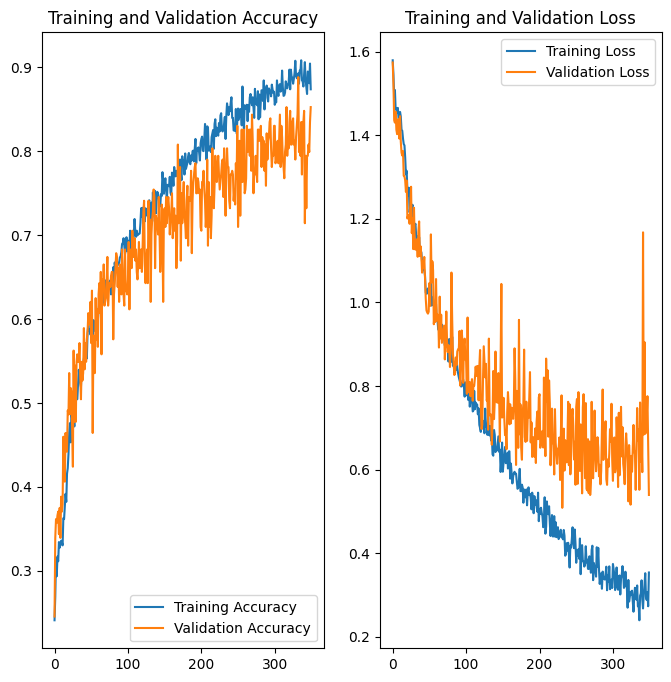

In [98]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [99]:
import numpy as np
np.argmax([0.02234267, 0.0589219, 0.17130046, 0.60764515, 0.13978986])

3

first image to predict
actual label: Cassava Brown Streak Disease (CBSD)
1/1 [==============================] - 0s 117ms/step
predicted label Cassava Green Mottle (CGM)


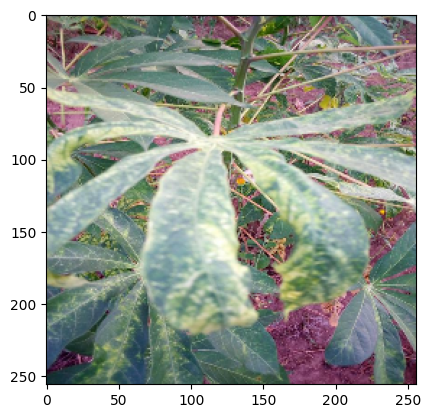

In [100]:
for images_batch, labels_batch in test_ds.take(1) :
  first_image = images_batch[0].numpy().astype('uint8')
  first_label = label_batch[0]

  print("first image to predict")
  plt.imshow(first_image)
  print("actual label:", class_names[first_label])

  batch_prediction = model.predict(images_batch)
  print("predicted label",class_names[np.argmax(batch_prediction[0])])

In [101]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 18ms/step


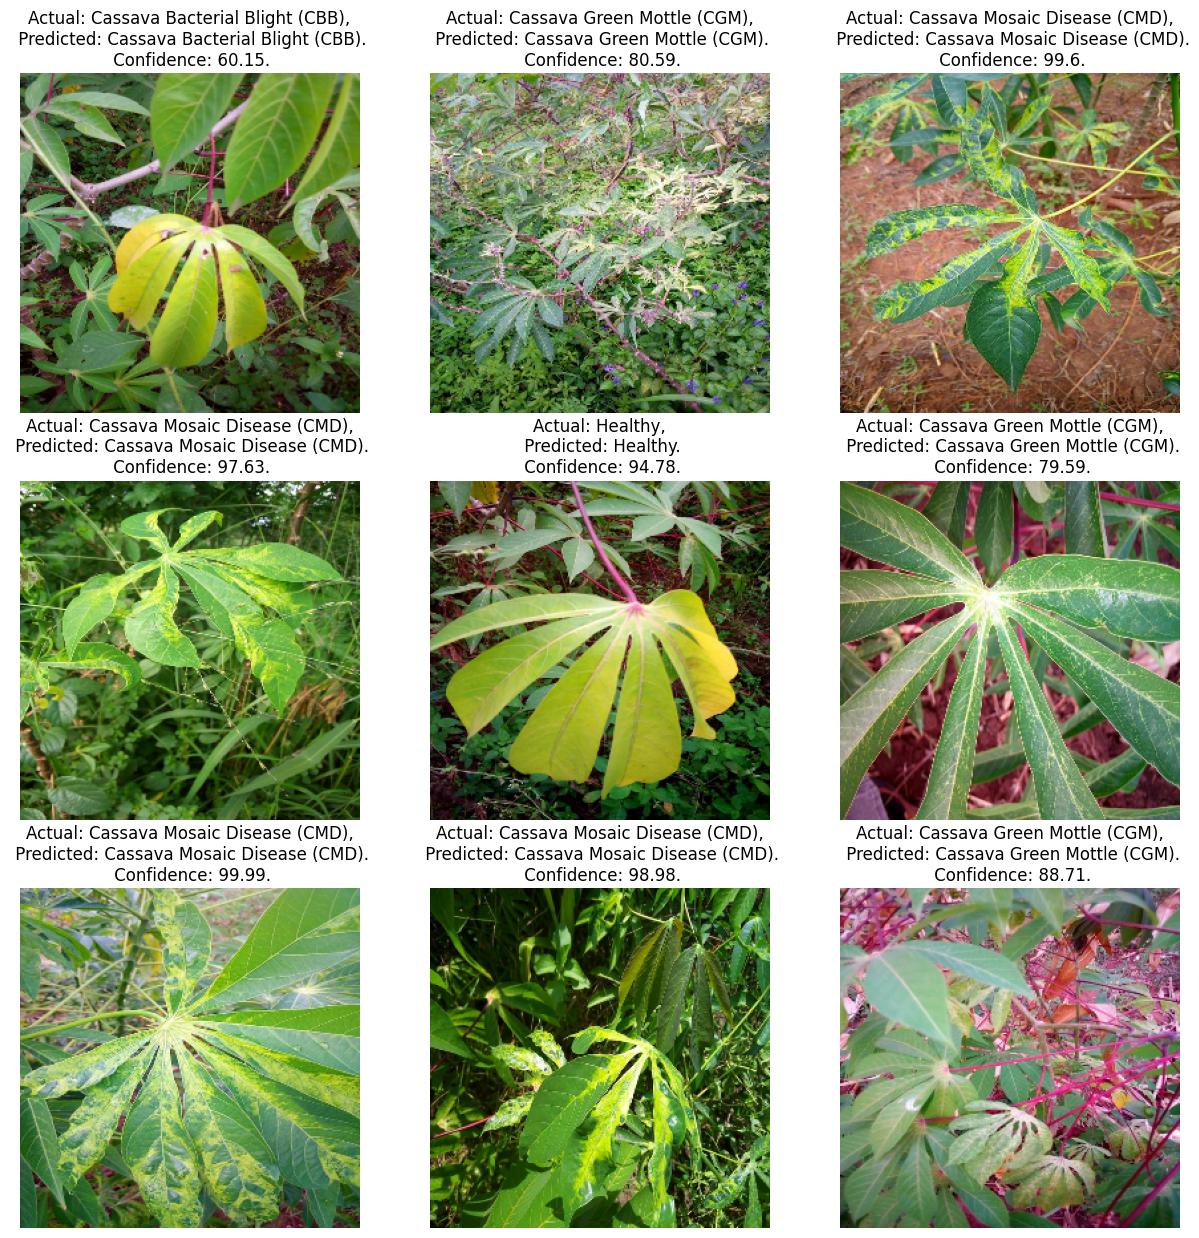

In [102]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}.")

        plt.axis("off")

In [103]:
import os

# Specify the path to the directory
directory_path = "/content/drive/MyDrive/CassavaDisease/model"

# Create the directory if it doesn't exist
os.makedirs(directory_path, exist_ok=True)

# Get the model version
model_version = max([int(i) for i in os.listdir(directory_path) + [0]]) + 1

# Save the model
model.save(f"{directory_path}/{model_version}")
